In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_columns = 1000
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score,make_scorer, confusion_matrix
import pickle
from category_encoders.one_hot import OneHotEncoder
import plotly.figure_factory as ff
import shap

#### local imports

In [2]:
from externals.plot import feature_importance_plot, feature_importance_shap_plot, score_distribution_plot, confusion_matrix_plot, threshold_search_plot, probability_pdf_perf, probability_cdf_perf,label_distribution_plot
from externals.undersampler import undersample_majority
from externals.tuning import ParameterTuning

#### Read Data

In [3]:
df = pd.read_csv("dataset/dataset.csv",sep = ";")
df = df.set_index("uuid")

In [4]:
df.shape

(99976, 42)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99976 entries, 63f69b2c-8b1c-4740-b78d-52ed9a4515ac to ac88f18c-96a6-49bc-9e9d-a780225914af
Data columns (total 42 columns):
default                                89976 non-null float64
account_amount_added_12_24m            99976 non-null int64
account_days_in_dc_12_24m              88140 non-null float64
account_days_in_rem_12_24m             88140 non-null float64
account_days_in_term_12_24m            88140 non-null float64
account_incoming_debt_vs_paid_0_24m    40661 non-null float64
account_status                         45603 non-null float64
account_worst_status_0_3m              45603 non-null float64
account_worst_status_12_24m            33215 non-null float64
account_worst_status_3_6m              42274 non-null float64
account_worst_status_6_12m             39626 non-null float64
age                                    99976 non-null int64
avg_payment_span_0_12m                 76140 non-null float64
avg_payment_span_0_3m       

In [6]:
# checking whether ids are unique or not
df.index.nunique() == df.shape[0]

True

#### final test data seperation

In [7]:
# seperating actual production test data from labelled data

final_test_data = df[df.default.isnull()]
df = df.dropna(subset = ["default"])

df.default.value_counts(normalize = True)

0.0    0.985685
1.0    0.014315
Name: default, dtype: float64

#### train test split before preprocessing

In [8]:
y = df.default
X = df.drop("default",axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### preprocessing

I kept the preprocessing step simple, as the feature names are unknown and no explanation given. I encode categorical features as one hot and give them to the model.

In [9]:
cat_cols = [
            'account_status',
            'account_worst_status_0_3m',
            'account_worst_status_12_24m',
            'account_worst_status_3_6m',
            'account_worst_status_6_12m',
            'merchant_category',
            'merchant_group',
            'name_in_email',
            'status_last_archived_0_24m',
            'status_2nd_last_archived_0_24m',
            'status_3rd_last_archived_0_24m',
            'status_max_archived_0_6_months',
            'status_max_archived_0_12_months',
            'status_max_archived_0_24_months',
            'worst_status_active_inv'
           ]

In [10]:
from category_encoders.one_hot import OneHotEncoder

In [11]:
ohe = OneHotEncoder(cat_cols)
X_train = ohe.fit_transform(X_train)

X_test = ohe.transform(X_test)

In [33]:
# saved the one hot encoder object to feed the production preprocessing steps

with open("saved_properties/one_hot_encoder.pickle", 'wb') as handle:
    pickle.dump(ohe, handle, protocol=pickle.HIGHEST_PROTOCOL)  

#### model training

In [13]:
sampling_rate = [1,.75,.5]

models = {}
train_data_ids = {}
results = {}

for i in sampling_rate: # due to class imbalance dataset, i'll try undersampling
    
    
    X_train, y_train = undersample_majority(X_train,y_train, i) # this function is defined in externals/undersampler.py. 
                                                                # only undersamples the majority class by taking sampling rate into account
    
    tuning = ParameterTuning(X_train, y_train, X_test, y_test) # this class is defined in externals/tuning.py
    clf = tuning.param_tuning(n_iter = 50, refit_metric = False,n_splits=3) # for dummy training, keep n_iter as 1

    res_tmp, model_dict = tuning.cv_results()
    
    # saving models, training data indexes and results
    models[i] = model_dict
    train_data_ids[i] = X_train.index.to_list()
    results[i] = res_tmp

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 88.0min finished


[23:53:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:57:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 81.3min finished


[01:20:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:20:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:22:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:24:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 36.3min finished


[02:04:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:04:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:04:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:04:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [32]:
# saving models, train data indexes, results and test data as pickle for possible future evaluations

with open("saved_properties/models.pickle", 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)   
with open("saved_properties/train_data_ids.pickle", 'wb') as handle:
    pickle.dump(train_data_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)   
with open("saved_properties/results.pickle", 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)   
    
with open("saved_properties/test_data.pickle", 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [19]:
results[1]

tn    fp   fn   tp  pred_cost    fpr  specifity  \
0  17433   297  179   87      0.801  0.990      0.983   
1  17673    57  227   39      0.736  0.987      0.997   
2  17673    57  227   39      0.736  0.987      0.997   
3  12190  5540   22  244      0.958  0.998      0.688   
4  14455  3275   49  217      0.939  0.997      0.815   
5  12190  5540   22  244      0.958  0.998      0.688   
6  17675    55  223   43      0.698  0.988      0.997   
7  14263  3467   49  217      0.942  0.997      0.804   

                 cost_type   prec    tnr    tpr  
0                      auc  0.227  0.983  0.327  
1                precision  0.406  0.997  0.147  
2                 f1_micro  0.406  0.997  0.147  
3                   recall  0.042  0.688  0.917  
4        balanced_accuracy  0.062  0.815  0.816  
5            neg_precision  0.042  0.688  0.917  
6                   profit  0.439  0.997  0.162  
7  tnr_tpr_optimizer_score  0.059  0.804  0.816

In [20]:
results[.75]

tn    fp   fn   tp  pred_cost    fpr  specifity  \
0  16681  1049  114  152      0.879  0.993      0.941   
1  17670    60  214   52      0.650  0.988      0.997   
2  17670    60  214   52      0.650  0.988      0.997   
3  11240  6490   17  249      0.963  0.998      0.634   
4  13326  4404   33  233      0.950  0.998      0.752   
5  11240  6490   17  249      0.963  0.998      0.634   
6  17670    60  214   52      0.650  0.988      0.997   
7  14289  3441   53  213      0.943  0.996      0.806   

                 cost_type   prec    tnr    tpr  
0                      auc  0.127  0.941  0.571  
1                precision  0.464  0.997  0.195  
2                 f1_micro  0.464  0.997  0.195  
3                   recall  0.037  0.634  0.936  
4        balanced_accuracy  0.050  0.752  0.876  
5            neg_precision  0.037  0.634  0.936  
6                   profit  0.464  0.997  0.195  
7  tnr_tpr_optimizer_score  0.058  0.806  0.801

In [21]:
results[.5]

tn    fp   fn   tp  pred_cost    fpr  specifity  \
0  13928  3802   39  227      0.944  0.997      0.786   
1  17503   227  192   74      0.792  0.989      0.987   
2  17503   227  192   74      0.792  0.989      0.987   
3   9896  7834   11  255      0.969  0.999      0.558   
4  13928  3802   39  227      0.944  0.997      0.786   
5   9896  7834   11  255      0.969  0.999      0.558   
6  17503   227  192   74      0.792  0.989      0.987   
7  13757  3973   48  218      0.949  0.997      0.776   

                 cost_type   prec    tnr    tpr  
0                      auc  0.056  0.786  0.853  
1                precision  0.246  0.987  0.278  
2                 f1_micro  0.246  0.987  0.278  
3                   recall  0.032  0.558  0.959  
4        balanced_accuracy  0.056  0.786  0.853  
5            neg_precision  0.032  0.558  0.959  
6                   profit  0.246  0.987  0.278  
7  tnr_tpr_optimizer_score  0.052  0.776  0.820

In [22]:
# This is the model i choose for the production. The reason is explained in the following cell
final_model = models[.75]["auc"]

Model selection decision is a business decision and can be made using various custom metrics by making a profitability analysis.
Opportunity cost, APR, cost of loss sale, cost of default should be taken into account while creating a metric to measure the model's profitability. 
What I cared about here was to find a model that minimizes sales loss and a model that captures at least 60% of the defaults.
I choose the model with sampling rate 1 and trained over AUC, since it made 6% loss of sales and correctly classified 57% of defaults.

In [31]:
# saved the model for production
with open("saved_properties/final_model.pickle", 'wb') as handle:
    pickle.dump(final_model, handle, protocol=pickle.HIGHEST_PROTOCOL)  

#### interpret model results

I used a shap plot to understand how feature values affect the model. This plot will help me understand if there is a bias in the model. Since I don't know the meaning of the feature, it doesn't mean anything right now, but a data scientist who has business knowledge and features can check the meaningfulness of the model by looking at this graph.


To deduce from the graph, the increase in the values of the "avg_payment_span_0_12m" feature positively affects the model score, while the increase in the "num_arch_ok_12_24m" feature decreases the model score.

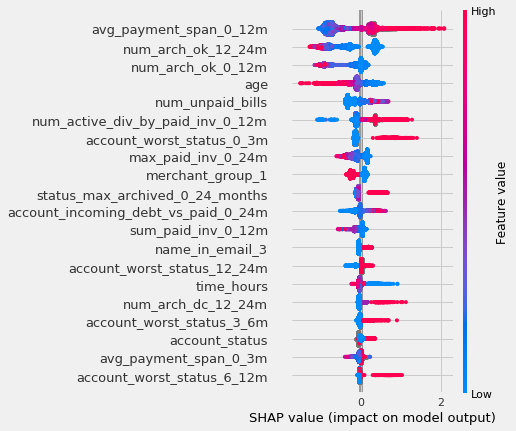

In [24]:
feature_importance_shap_plot(final_model,X_test)

#### score distributions

As expected, our model tends to score higher on defaults. But this graph is in the normalized, so a sharp separation appears.

In [25]:
pr = pd.DataFrame(final_model.predict_proba(X_test)[:,1], index = X_test.index)
pr.columns = ["prob"]
pr["true"] = y_test
label_distribution_plot(pr)

#### score distibution and precision under different score intervals

Our precision values seem low due to class imbalance.

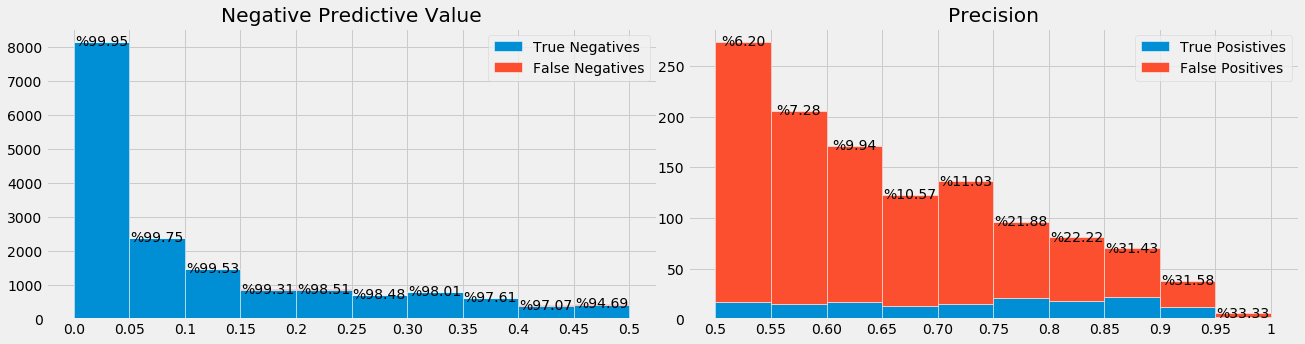

In [26]:
score_distribution_plot(final_model,X_test,y_test)

#### TNR and TPR change observation for threshold selection

This graph shows the variation of tnr and tpr according to different thresholds. If it was necessary to set a threshold, it could be selected here according to the business decision.

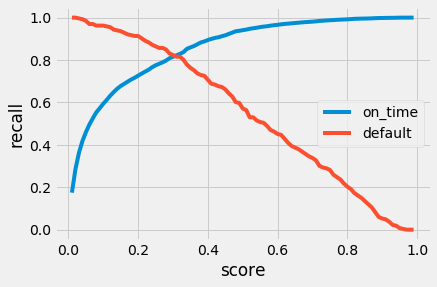

In [27]:
threshold_search_plot(final_model,X_test,y_test)

#### model behaviour with different thresholds

Thresholding is useful in such problems. so I plotted confusion matrices to see model performance at different thresholds

Pred Cost: 0.938, fpr:  0.997, specifity:  0.815
Pred Cost: 0.936, fpr:  0.997, specifity:  0.822
Pred Cost: 0.934, fpr:  0.997, specifity:  0.829
Pred Cost: 0.932, fpr:  0.996, specifity:  0.837
Pred Cost: 0.928, fpr:  0.996, specifity:  0.853
Pred Cost: 0.926, fpr:  0.996, specifity:  0.860
Pred Cost: 0.924, fpr:  0.996, specifity:  0.866
Pred Cost: 0.921, fpr:  0.996, specifity:  0.875
Pred Cost: 0.916, fpr:  0.995, specifity:  0.883
Pred Cost: 0.914, fpr:  0.995, specifity:  0.888
Pred Cost: 0.911, fpr:  0.995, specifity:  0.894
Pred Cost: 0.909, fpr:  0.995, specifity:  0.900
Pred Cost: 0.906, fpr:  0.995, specifity:  0.904
Pred Cost: 0.904, fpr:  0.995, specifity:  0.907
Pred Cost: 0.900, fpr:  0.995, specifity:  0.912
Pred Cost: 0.897, fpr:  0.994, specifity:  0.917
Pred Cost: 0.892, fpr:  0.994, specifity:  0.923
Pred Cost: 0.887, fpr:  0.994, specifity:  0.929
Pred Cost: 0.882, fpr:  0.994, specifity:  0.936
Pred Cost: 0.879, fpr:  0.994, specifity:  0.938
Pred Cost: 0.879, fp

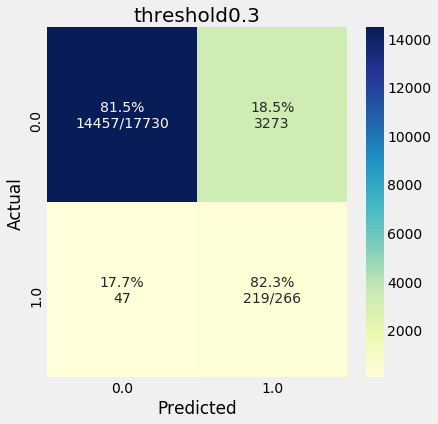

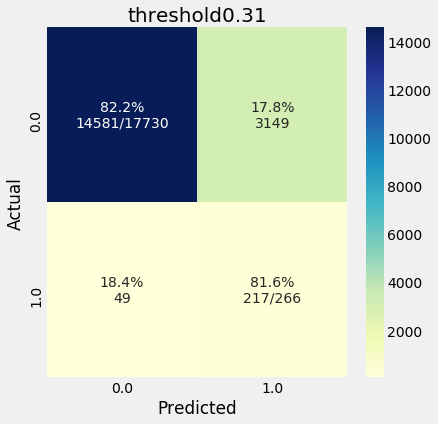

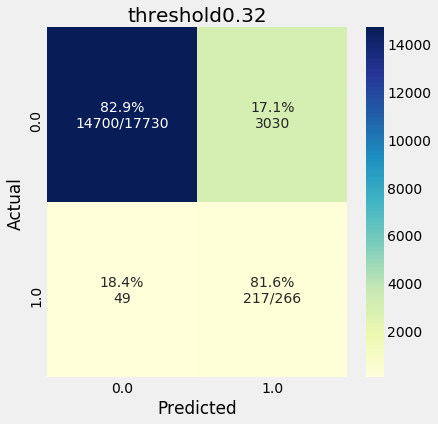

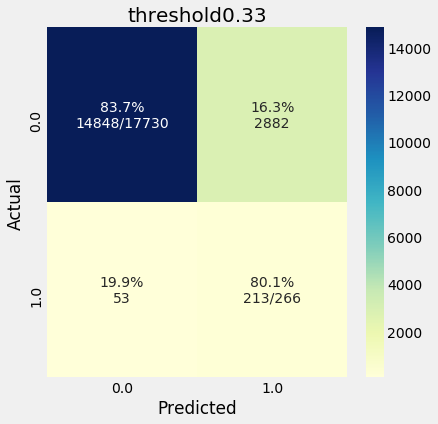

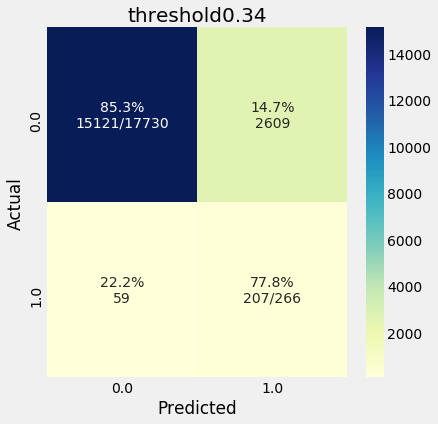

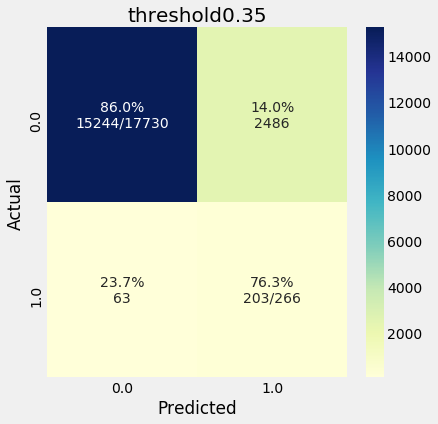

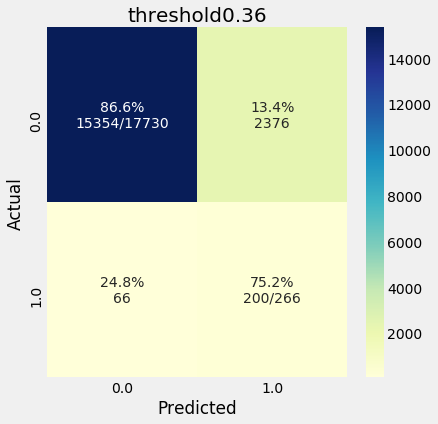

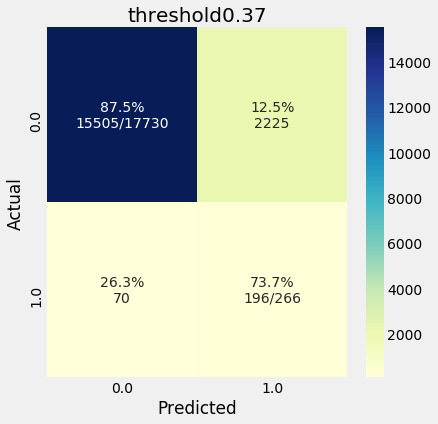

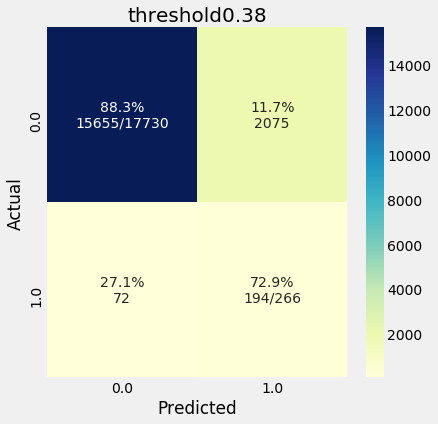

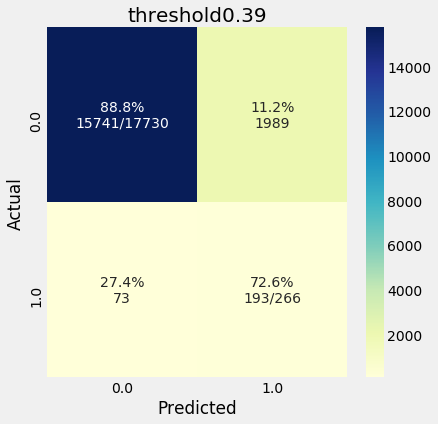

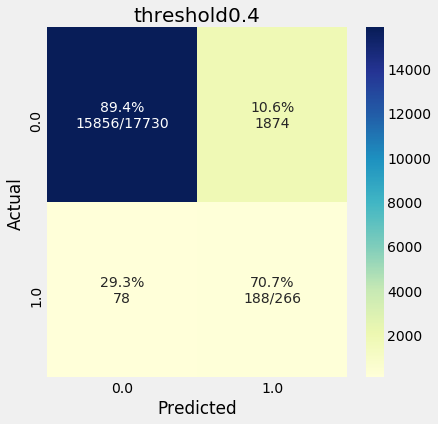

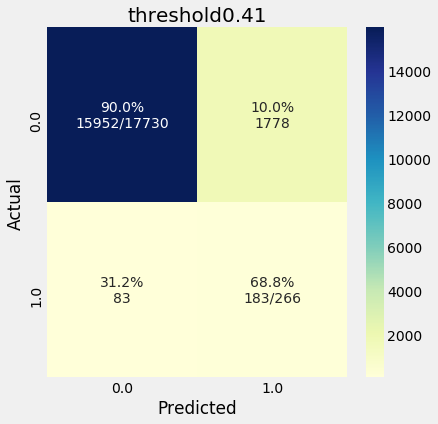

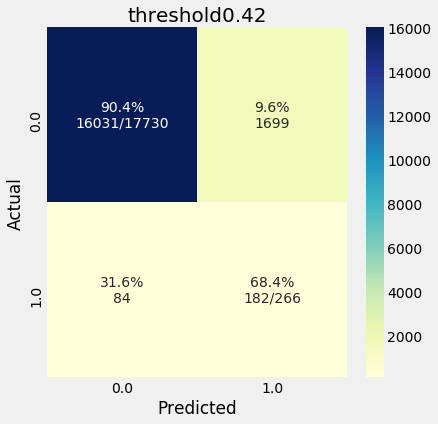

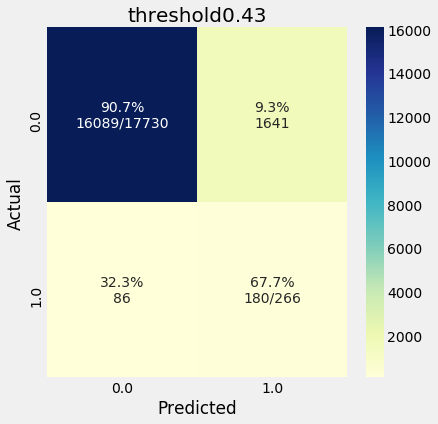

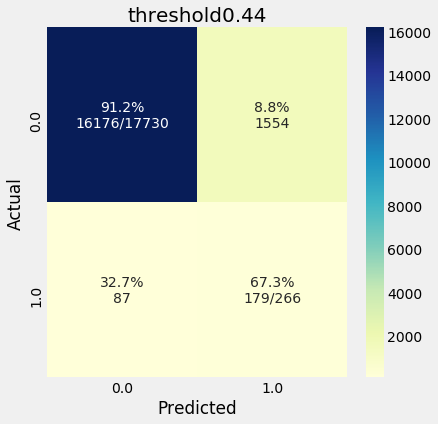

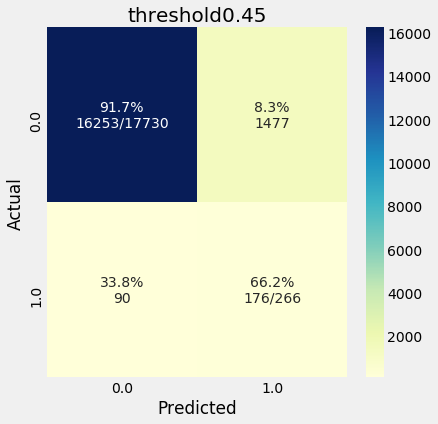

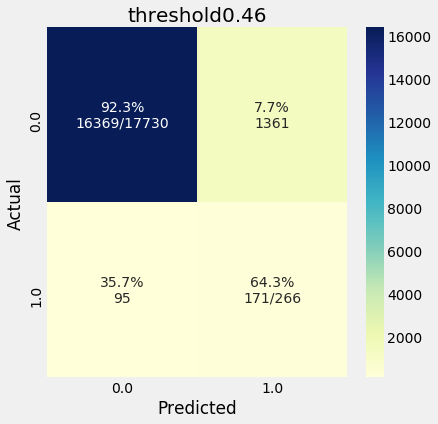

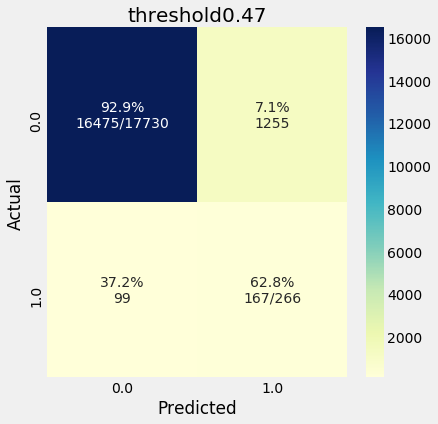

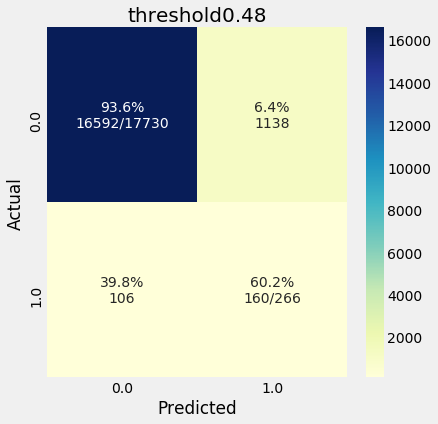

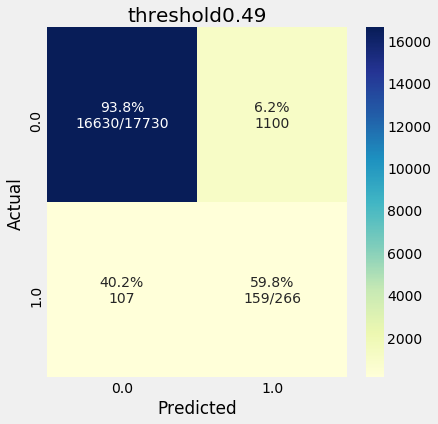

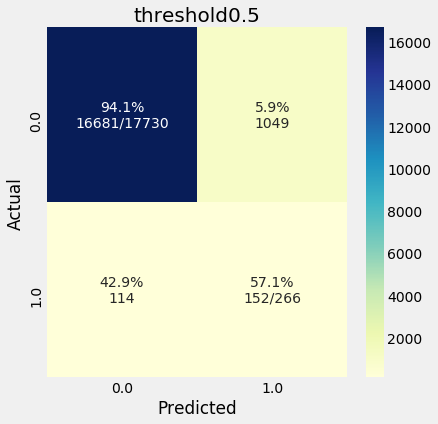

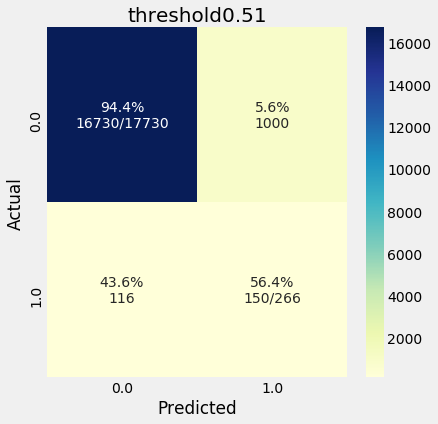

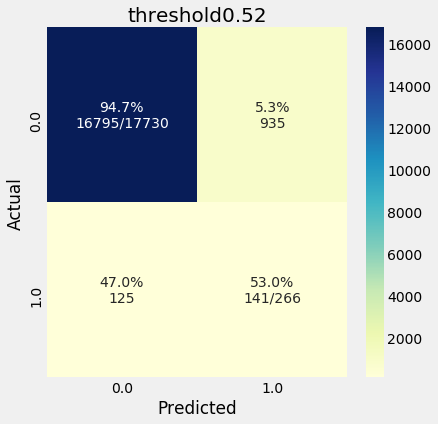

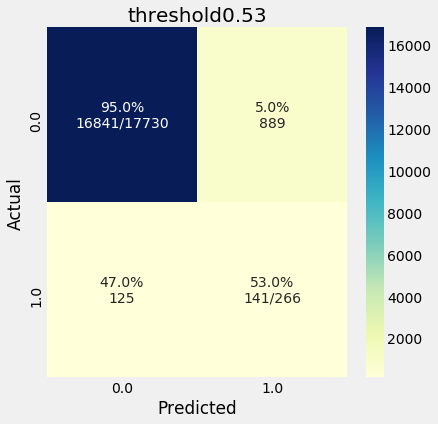

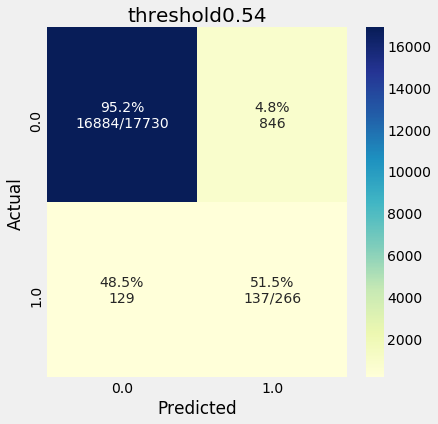

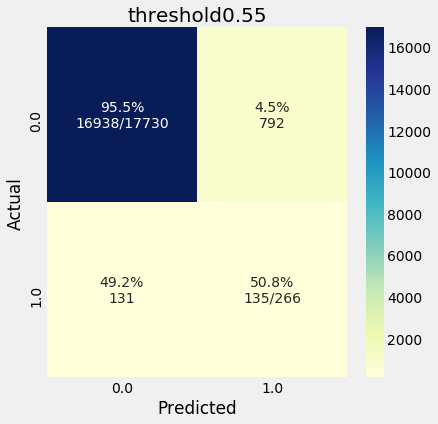

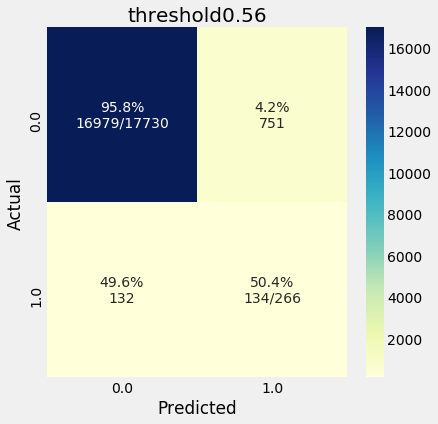

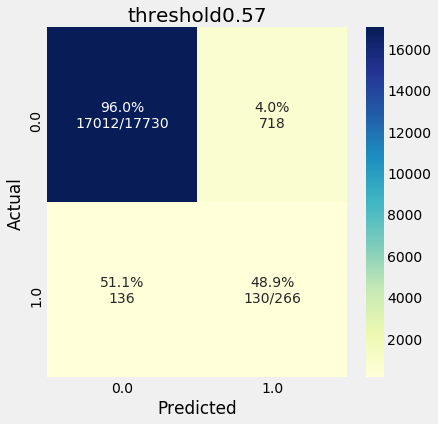

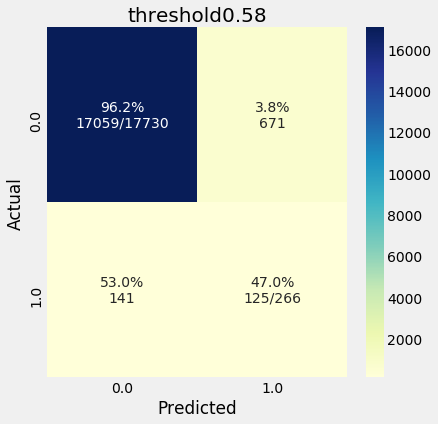

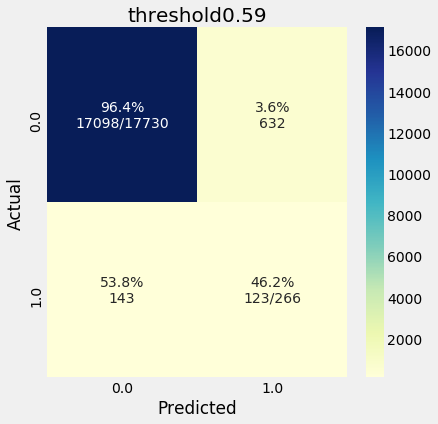

In [28]:
for test_th in range(30,60,1):
    confusion_matrix_plot(y_test, np.where(final_model.predict_proba(X_test)[:,1] >= test_th/100, 1, 0), "threshold" + str(test_th/100),(6,6))

#### what if we apply 2 distinct threshold? Observe auto decision coverage and performance

If we had approached the problem differently and divided it into approval, rejection and gray areas, it would have been possible to calculate the threshold by looking at the metrics with different threshold values with the code below. 

- if score < threshold_lower : Reject the application
- if score > threshold_upper : Approve the applicaton
- if score in between them: Gray area (Loan officers may asses the application manually)

In [29]:
def double_threshold_report(clf, x_test, y_test,thl, thu):
    prob = clf.predict_proba(x_test)
    res = pd.DataFrame(prob[:,1], columns = ["score"])
    res.index = y_test.index
    res["true"] = y_test
    res["pred"] = 1

    
    idx = res[res["score"] < thl].index
    res.loc[idx, "pred"] = 0


    tmp = res[(res["score"] >= thu) | (res["score"] <= thl)]
    tp = len(tmp[(tmp["pred"] == 1) & (tmp["true"] == 1)])
    fp = len(tmp[(tmp["pred"] == 1) & (tmp["true"] == 0)])
    fn = len(tmp[(tmp["pred"] == 0) & (tmp["true"] == 1)])
    tn = len(tmp[(tmp["pred"] == 0) & (tmp["true"] == 0)])
    print("roc_auc",roc_auc_score(tmp["true"], tmp["pred"]))
    print("tp:",tp," fp:",fp," tn:",tn, " fn:",fn) 
    print("auto decision covarage:",(tp+fp+tn+fn)/len(res))
    print("precision:",tp/(tp + fp))
    print("neg_precision:",tn/(tn + fn))
    print("1-precsision:",(1-tp/(tp + fp)))
    print("test_size:",len(res))
    print("recall:",tp/(tp + fn))

In [30]:
double_threshold_report(final_model,X_test,y_test,0.5,.9)

roc_auc 0.5537898876488541
tp: 14  fp: 30  tn: 16681  fn: 114
auto decision covarage: 0.9357079350966881
precision: 0.3181818181818182
neg_precision: 0.9932122655552248
1-precsision: 0.6818181818181819
test_size: 17996
recall: 0.109375


# Getting score from the AWS cloud services



Run the following code on your terminal to get score of corresponding uuid
It will be enough to change the uuid and send a request. 

In [55]:
!curl -XPOST "https://5pwx4y80a8.execute-api.us-east-2.amazonaws.com/klarnaStage" -d '{"uuid":"6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7"}'

{"statusCode": 200, "error": null, "uuid": "6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7", "score": "0.097184"}

# Test data prediction

In [37]:
final_test_data = final_test_data.drop("default",axis = 1)
final_test_data = ohe.transform(final_test_data)
final_test_data = final_test_data[X_train.columns]

In [45]:
predictions = final_model.predict_proba(final_test_data)[:,1]
overall_test_data_results = pd.Series(predictions,index = final_test_data.index,name = "pd").reset_index()

In [49]:
overall_test_data_results.head()

uuid        pd
0  6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7  0.097184
1  f6f6d9f3-ef2b-4329-a388-c6a687f27e70  0.146523
2  e9c39869-1bc5-4375-b627-a2df70b445ea  0.049657
3  6beb88a3-9641-4381-beb6-c9a208664dd0  0.392539
4  bb89b735-72fe-42a4-ba06-d63be0f4ca36  0.533475